# Graph-to-Hypergraph Node Centrality Lifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
***


### Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2

from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

## Loading the Dataset

Here we just need to spicify the name of the available dataset that we want to load. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.


In [2]:
dataset_name = "manual_dataset"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for manual_dataset:

{'data_domain': 'graph',
 'data_type': 'toy_dataset',
 'data_name': 'manual',
 'data_dir': 'datasets/graph/toy_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node'}


We can then access to the data through the `load()`method:


Dataset only contains 1 sample:


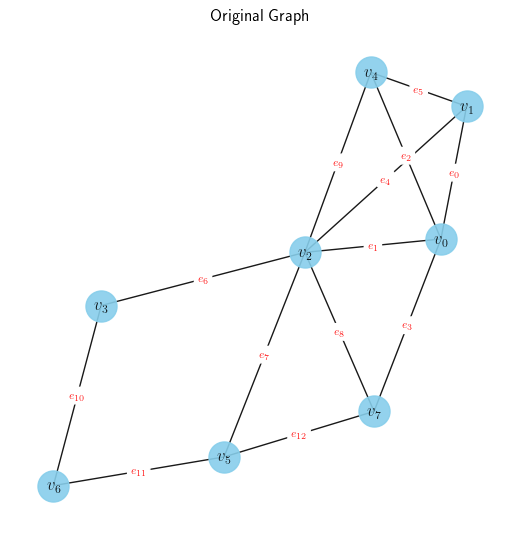

 - Graph with 8 vertices and 13 edges.
 - Features dimensions: [1, 0]
 - There are 0 isolated nodes.



In [3]:
dataset = loader.load()
describe_data(dataset)

In [4]:
type(dataset)

modules.data.utils.custom_dataset.CustomDataset

## Loading and Applying the Lifting

**Motivation**
In this section, we will instantiate the lifting we want to apply to the data. This is a novel lifting that creates hyperedges based on central, i.e. highly influential, nodes in the network. Mapping a connection between individual nodes to specific nodes in the network architecture that have a specific and potentially competing influence on them is a very convenient scenario to be modelled via hyperedges. Using shortest path distance to identify the most influential nodes on any given node even allows for placing weights on the hyperedge connection to individual, connected nodes (i.e. the inverse shortest path distance to the corresponding most influential node that the hyperedge represents). To define and identify influential nodes in the network, we refer to the variant of the Eigenvector Centrality with an additional jump probability (i.e. PageRank).

**Background**
Eigenvector Centrality is an algorithm that measures the transitive influence of nodes. Relationships originating from high-scoring nodes contribute more to the score of a node than connections from low-scoring nodes. A high eigenvector score means that a node is connected to many nodes who themselves have high scores.

The algorithm computes the eigenvector associated with the largest absolute eigenvalue. To compute that eigenvalue, the algorithm applies the power iteration approach. Within each iteration, the centrality score for each node is derived from the scores of its incoming neighbors. In the power iteration method, the eigenvector is L2-normalized after each iteration, leading to normalized results by default.

The PageRank [[1]](https://doi.org/10.1137/140976649) variant of Eigenvector Centrality utilises, at any step of the power iteration, an additional jump probability, called dampening factor $\alpha$, which decides whether to continue following the transition matrix or teleport to random positions in the process.These random teleportations have shown to be an effective way to ensure that the matrix and corresponding Markov chain exhibit ergodicity which makes them easier to analyze and to guarantee convergence.

**Method**
Our approach is applicable to both directed and undirected as well as weighted and unweighted networks. It works as follows: (1) calculate the node centrality of all nodes in the graph, (2) select the top $n$ most influential nodes in the graph as hyperedges based on a given quantile. (3) Assign all nodes in the network to $m >= 1$ most influential nodes (with $m <= n$), i.e. their respective hyperedges, based on their shortest path distance $d$ to each influential node. (4, optional) model individual connection weights per node to a hyperedge via the inverse shortest path distance (i.e. $1/d$) to the hyperedge's corresponding most influential node. 

**Remarks on feature liftings**
Note that the algorithm currently supports the utilization of the ProjectionSum feature lifting to model the inverse relationship between all nodes towards their shared most influential node. In order to model the direct influence of the influential node on all individual nodes via the hyperedge, we have, however, further implemented a straight-forward feature lifting via assignment of the hyperedge's corresponding node's features, thereby bypassing the ProjectionSum feature lifting.


***
[[1]](https://doi.org/10.1137/140976649) Gleich, D.F. (2015) PageRank Beyond the Web. SIAM Review, 57, 321-363.
***


For hypergraphs, creating a lifting involves creating the `incidence_hyperedges` matrix.

Similarly to before, we can specify the transformation we want to apply through its type and id --the corresponding config files located at `/configs/transforms.` 

Note that the *tranform_config* dictionary generated below can contain a sequence of transforms if it is needed.

This can also be used to explore liftings from one topological domain to another; for example, using two liftings, it is possible to achieve a sequence such as graph -> simplicial complex -> hypergraph. 

In [5]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2hypergraph/node_centrality_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for graph2hypergraph/node_centrality_lifting:

{'transform_type': 'lifting',
 'transform_name': 'HypergraphNodeCentralityLifting',
 'network_type': 'weighted',
 'alpha': 0.85,
 'th_percentile': 0.05,
 'n_most_influential': 2,
 'do_weight_hyperedge_influence': False,
 'do_hyperedge_node_assignment_feature_lifting_passthrough': False,
 'max_iter': 100,
 'tol': 1e-06,
 'feature_lifting': 'ProjectionSum'}


We than apply the transform via our `PreProcessor`:


Dataset only contains 1 sample:


Processing...
Done!


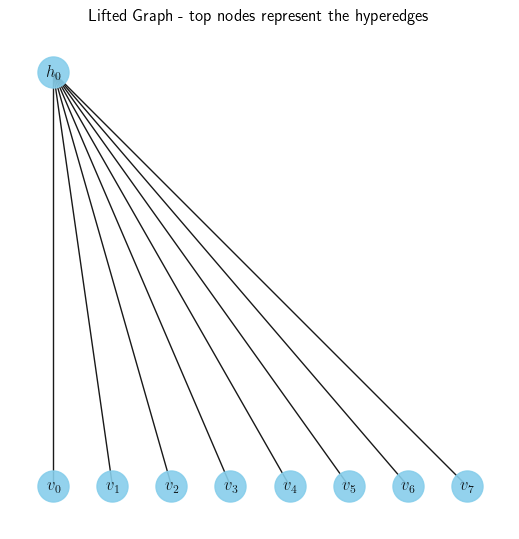

 - Hypergraph with 8 vertices and 1 hyperedges.
 - The nodes have feature dimensions 1.
 - The hyperedges have feature dimensions 1.



In [6]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

Given the stringent percentile threshold (i.e. 0.05), the algorithm detects one most influential node, hence one hyperedge.


Dataset only contains 1 sample:


Processing...
Done!


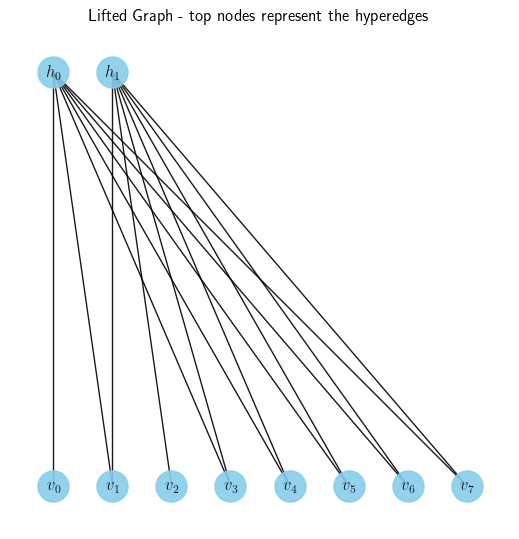

 - Hypergraph with 8 vertices and 2 hyperedges.
 - The nodes have feature dimensions 1.
 - The hyperedges have feature dimensions 1.



In [7]:
transform_config["lifting"]["th_percentile"] = 0.2
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

A more lenient threshold leads to the selection of two most influential nodes. Further we observe the effect of passing through the feature lifting (based on projectiveSum) and assigning each influential node's features directly to the corresponding hyperedges. 

In [9]:
print(lifted_dataset.get(0))
print(lifted_dataset.get(0).x_hyperedges)

transform_config["lifting"][
    "do_hyperedge_node_assignment_feature_lifting_passthrough"
] = True
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)

print(lifted_dataset.get(0))
print(lifted_dataset.get(0).x_hyperedges)

Data(x=[8, 1], edge_index=[2, 13], y=[8], num_nodes=8, incidence_hyperedges=[8, 2], num_hyperedges=2, x_0=[8, 1], x_hyperedges=[2, 1])
tensor([[ 1.],
        [10.]])
Transform parameters are the same, using existing data_dir: /Users/michael/perelyn/research/topological_deep_learning/challenge-icml-2024/datasets/graph/toy_dataset/manual/lifting/2688954955
Data(x=[8, 1], edge_index=[2, 13], y=[8], num_nodes=8, incidence_hyperedges=[8, 2], num_hyperedges=2, x_0=[8, 1], x_hyperedges=[2, 1])
tensor([[ 1.],
        [10.]])



Dataset only contains 1 sample:


Processing...
Done!


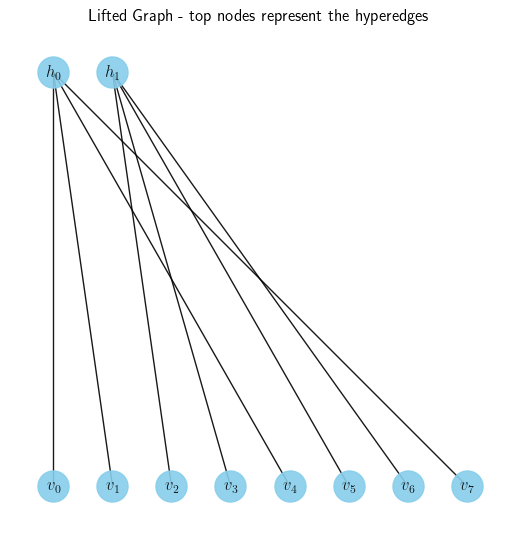

 - Hypergraph with 8 vertices and 2 hyperedges.
 - The nodes have feature dimensions 1.
 - The hyperedges have feature dimensions 1.



In [10]:
transform_config["lifting"]["n_most_influential"] = 1
transform_config["lifting"]["th_percentile"] = 0.2
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

Assigning nodes only to one of the two most influential nodes leads to a uniqe assignment to hyperedges

## Create and Run a Simplicial NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `incidence_hyperedges` matrix so the lifting should make sure to add it to the data.

In [11]:
from modules.models.hypergraph.unigcn import UniGCNModel

model_type = "hypergraph"
model_id = "unigcn"
model_config = load_model_config(model_type, model_id)

model = UniGCNModel(model_config, dataset_config)


Model configuration for hypergraph UNIGCN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2}


In [12]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors. 

Let's try another example, i.e. chemical structures from the MUTAG dataset, where node an edge features are > 1, hence the algorithm switches to the unweighted version automatically. 

In [13]:
dataset_name = "MUTAG"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for MUTAG:

{'data_domain': 'graph',
 'data_type': 'TUDataset',
 'data_name': 'MUTAG',
 'data_dir': 'datasets/graph/TUDataset',
 'num_features': [7, 4],
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'graph',
 'max_dim_if_lifted': 2,
 'preserve_edge_attr_if_lifted': False}



Dataset contains 188 samples.

Providing more details about sample 0/188:


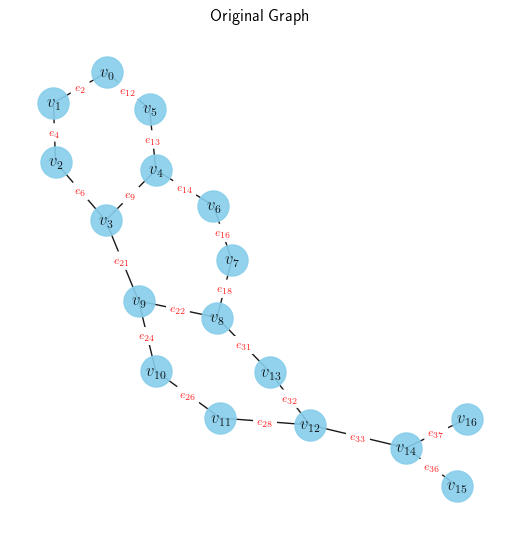

 - Graph with 17 vertices and 38 edges.
 - Features dimensions: [7, 4]
 - There are 0 isolated nodes.



In [14]:
dataset = loader.load()
describe_data(dataset)

In [16]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2hypergraph/node_centrality_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for graph2hypergraph/node_centrality_lifting:

{'transform_type': 'lifting',
 'transform_name': 'HypergraphNodeCentralityLifting',
 'network_type': 'weighted',
 'alpha': 0.85,
 'th_percentile': 0.05,
 'n_most_influential': 2,
 'do_weight_hyperedge_influence': False,
 'do_hyperedge_node_assignment_feature_lifting_passthrough': False,
 'max_iter': 100,
 'tol': 1e-06,
 'feature_lifting': 'ProjectionSum'}


Processing...



Dataset contains 188 samples.

Providing more details about sample 0/188:


Done!


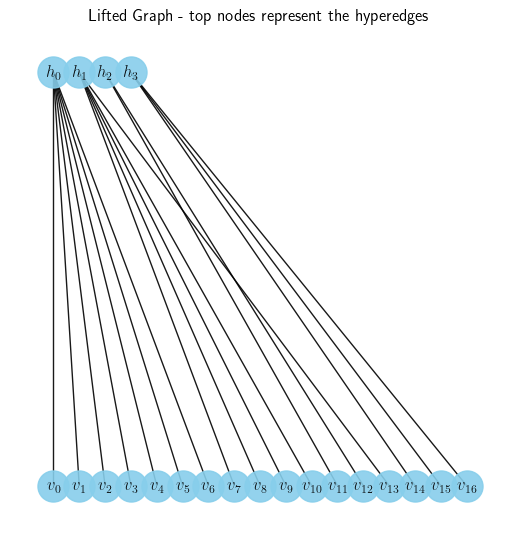

 - Hypergraph with 17 vertices and 4 hyperedges.
 - The nodes have feature dimensions 7.
 - The hyperedges have feature dimensions 7.



In [18]:
transform_config["lifting"]["n_most_influential"] = 1
transform_config["lifting"]["th_percentile"] = 0.2
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)